In [20]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]='1'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout
from keras import Sequential, Input

load data from csv

In [8]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences/'

data = []

labels = None
no_labels = None

no_features: int = None

count = 0
for file_name in os.listdir(data_directory):
    count += 1
    if count % 50000 == 0:
        print(f'Loaded {count} sequences')
    with open(data_directory + file_name, 'r') as f:
        label = file_name.split('_')[0]
        # build dictionary with counts of events
        datapoint = {}
        for line in f:
            line = line.strip()
            if line in datapoint:
                datapoint[line] += 1
            else:
                datapoint[line] = 1
        data.append((label, datapoint))


print(f'Loaded {len(data)} datapoints')

# filter out datapoints where label occurres less than 10 times
label_occurrences = {}
for label, _ in data:
    if label in label_occurrences:
        label_occurrences[label] += 1
    else:
        label_occurrences[label] = 1
data = [ x for x in data if label_occurrences[x[0]] >= 10 ]

print(f'Filtered out datapoints with less than 10 occurrences')
print(f'Left with {len(data)} datapoints')

random.shuffle(data)
labels = [ x[0] for x in data ]
data = [ x[1] for x in data ]

distinct_labels = np.unique(np.array(labels))
no_labels = len(distinct_labels)
print(f'Found {no_labels} distinct labels')

# get distinct features
distinct_features = set()
for datapoint in data:
    distinct_features.update(datapoint.keys())
distinct_features = np.array(list(distinct_features))
no_features = len(distinct_features)
print(f'Found {no_features} distinct features')

# encode labels from strings to integers to one-hot
labels = np.eye(no_labels)[np.vectorize(distinct_labels.tolist().index)(labels)]
print(f'Encoded labels to one-hot')

# encode features from dictionary to numpy array
data_encoded = []
for datapoint in data:
    datapoint_encoded = np.zeros(no_features)
    for feature, count in datapoint.items():
        datapoint_encoded[distinct_features.tolist().index(feature)] = count
    data_encoded.append(datapoint_encoded)

# get pad event to pad sequences with when batches are built
pad_event = np.zeros(no_features)

Loaded 50000 sequences
Loaded 100000 sequences
Loaded 150000 sequences
Loaded 200000 sequences
Loaded 250000 sequences
Loaded 300000 sequences
Loaded 350000 sequences
Loaded 400000 sequences
Loaded 430863 datapoints
Filtered out datapoints with less than 10 occurrences
Left with 430661 datapoints
Found 77 distinct labels
Found 29 distinct features
Encoded labels to one-hot


build model

In [11]:
model = Sequential(layers=[
    Input(shape=(no_features,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(no_labels, activation='softmax')
])
model.summary()

2024-06-12 17:16:47.081591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 77)             │         5,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245 (59.55 KB)

 Trainable params: 15,245 (59.55 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto'
)

checkpoint_path = ("/home/jrosendahl/sync/models/checkpoints")
model_checkpoint = ModelCheckpoint(
    filepath=f'{checkpoint_path}/ffn.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-6
)

csv_logger = CSVLogger(
    filename=f'{checkpoint_path}/ffn.log',
    append=True
)


# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(optimizer='adam', loss='categorical_focal_crossentropy', metrics=['accuracy'])

train model

In [31]:
# split data into training and validation
split = int(len(data_encoded) * 0.8)

X_train = np.array(data_encoded[:split])
y_train = np.array(labels[:split])

X_val = np.array(data_encoded[split:])
y_val = np.array(labels[split:])

print(f'Training on {len(X_train)} samples')
print(f'Validating on {len(X_val)} samples')

Training on 344528 samples
Validating on 86133 samples


In [23]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stop, model_checkpoint, lr_schedule, csv_logger]
)

# save history to file
with open(f'{checkpoint_path}/ffn_history.npy', 'wb') as f:
    np.save(f, history.history)

Epoch 1/50
10767/10767 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9311 - loss: 0.0697
Epoch 1: val_loss improved from inf to 0.03199, saving model to /home/jrosendahl/sync/models/checkpoints/ffn.keras
10767/10767 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.9311 - loss: 0.0697 - val_accuracy: 0.9410 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 2/50
10759/10767 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9405 - loss: 0.0316
Epoch 2: val_loss improved from 0.03199 to 0.03078, saving model to /home/jrosendahl/sync/models/checkpoints/ffn.keras
10767/10767 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9405 - loss: 0.0316 - val_accuracy: 0.9413 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 3/50
10750/10767 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9403 - loss: 0.0300
Epoch 3: val_loss did not improve from 0.03078
10767/10767 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9403 - loss: 0.0300 - val_accuracy: 0.9414 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 4/50


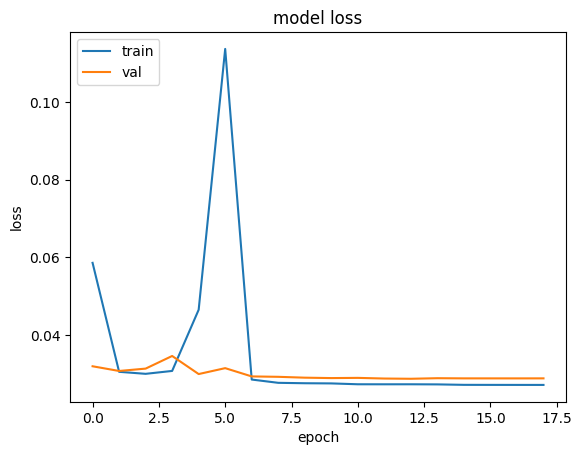

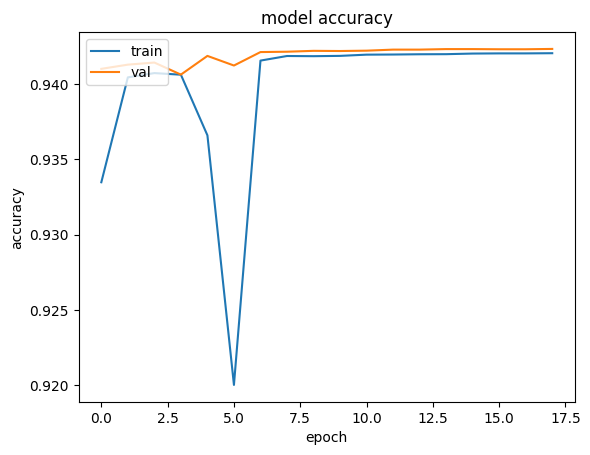

In [25]:
# plot history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
# evaluate model
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.028879929333925247
Test accuracy: 0.9423449635505676


In [32]:
# print report
predictions = model.predict(X_val)
predictions = np.argmax(predictions, axis=1)
y_val_argmax = np.argmax(y_val, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_val_argmax, predictions, target_names=distinct_labels, zero_division=np.nan))


2692/2692 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
                 precision    recall  f1-score   support

      adjkerntz        nan      0.00      0.00        25
         alpine       0.99      0.64      0.78       201
          anvil       0.97      1.00      0.98       183
          atrun       1.00      1.00      1.00       624
            awk       1.00      1.00      1.00        10
       basename        nan      0.00      0.00         3
           bash       0.95      0.97      0.96     32051
          bzcat       0.40      1.00      0.57         2
          bzip2       1.00      1.00      1.00         2
            cat       0.88      0.96      0.92        76
         chkgrp        nan      0.00      0.00         3
        cleanup       1.00      1.00      1.00       227
            cmp       1.00      1.00      1.00        11
             cp       1.00      1.00      1.00         2
           cron       1.00      1.00      1.00      2036
           date       1.00      1.00      1.

: 